### Installation

In [1]:
# !pip install tensorflow

In [2]:
# !pip install tensorflow_hub

In [3]:
# !pip install torch

In [4]:
# pip install opencv-python==4.5.5.64

In [5]:
# !pip install imgaug

### Import Libraries

In [1]:
import torch #pytorch
import torchvision
import torch.nn as nn #pytorch network
import torch.nn.functional as F
from torchvision import transforms #torchvision transform

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### GPU Checking

In [2]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")
if torch.cuda.is_available(): print(f'device name: {torch.cuda.get_device_name(0)}')

Using cuda device
device name: Quadro RTX 4000 with Max-Q Design



### Version Checking

In [3]:
import sys
print(sys.version)

3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]


In [4]:
cv2.__version__

'4.5.5'

In [5]:
print(torch.__version__)

1.11.0


### Data Preprocessing

1) Visualize image and bounding boxes

(1333, 2000, 3)


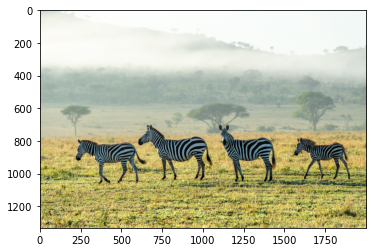

In [10]:
# In this example, only use 1 image, i.e, batch_size=1
# input image could be of any size

img0 = cv2.imread("zebras.jpg")
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
print(img0.shape)
plt.imshow(img0)
plt.show()

In [7]:
# 주어진 하나의 Image에 대한 정답 데이터 지정!
# Bounding Box Label Data와 Class Label Data를 동시에 줘야 Object Detecting 가능!

# object information : a set of bounding boxes [x1, y1, x2, y2] 
# and their labels
bbox0 = np.array([[223, 782, 623, 1074], [597, 695, 1038, 1050], 
                  [1088, 699, 1452, 1057], [1544, 771, 1914, 1063]]) 
labels = np.array([1, 1, 1, 1]) # 0: background, 1: zebra

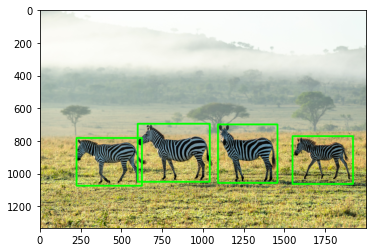

In [8]:
# display bounding box and labels

img0_clone = np.copy(img0)
for i in range(len(bbox0)):
    cv2.rectangle(img0_clone, (bbox0[i][0], bbox0[i][1]), 
                              (bbox0[i][2], bbox0[i][3]),
                 color=(0, 255, 0), thickness=10)
plt.imshow(img0_clone)
plt.show()

### 2) Resize image and bounding boxes

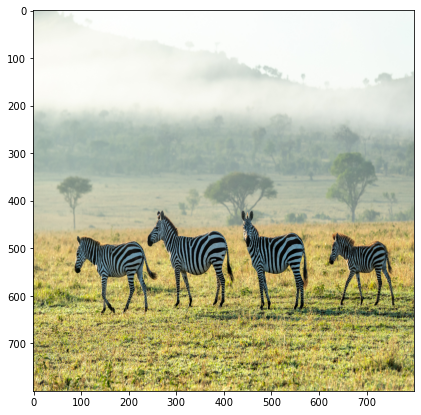

In [14]:
# resize the input images to h=800, w=800
# CNN의 Input으로 들어갈 수 있는 Size로 Resizing!

img = cv2.resize(img0, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.show()

In [15]:
# 기존의 이미지가 Resize되었기에, 같은 비율만큼 Bounding Box도 Resize해야한다.

# change the bounding box coordinates
# original image size : (1333, 2000)

Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]

print(Wratio, Hratio)

0.4 0.6001500375093773


In [20]:
# Example Code of Zip

ratioList = [Wratio, Hratio, Wratio, Hratio]
box = [100,200,300,4000]

for a, b in zip(box,ratioList):
    print(a, b)

100 0.4
200 0.6001500375093773
300 0.4
4000 0.6001500375093773


[[ 89 469 249 644]
 [238 417 415 630]
 [435 419 580 634]
 [617 462 765 637]]


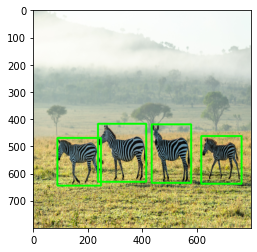

In [18]:
ratioList = [Wratio, Hratio, Wratio, Hratio]
bbox = []

for box in bbox0:
    box = [int(a*b) for a, b in zip(box, ratioList)]
    bbox.append(box)
    
bbox = np.array(bbox)
print(bbox)

img_clone = np.copy(img)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), color=(0, 255, 0), thickness=5)
plt.imshow(img_clone)
plt.show()

In [19]:
ratioList = [Wratio, Hratio, Wratio, Hratio]
bbox = []
zip(box, ratioList)